# C_CURRENT_MAX

## Setup

In [ ]:
# If necessary:
import os
os.remove('snorkel.db')

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

## Parsing

In [ ]:
from snorkel import SnorkelSession
session = SnorkelSession()

### Define Parser

In [ ]:
import os
from snorkel.parser import CorpusParser, HTMLParser, OmniParser
from snorkel.utils import get_ORM_instance
from snorkel.queries import split_corpus

docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_html/'
doc_parser = HTMLParser(path=docs_path)
context_parser = OmniParser()
cp = CorpusParser(doc_parser, context_parser, max_docs=100) 

### Run Parser

In [ ]:
%time corpus = cp.parse_corpus(name='Hardware', session=session)

session.add(corpus)
session.commit()

### Split Corpus

In [ ]:
from snorkel.models import Corpus

corpus = get_ORM_instance(Corpus, session, 'Hardware')
split_corpus(session, corpus, train=0.8, development=0.2, test=0, seed=4)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ corpus snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

In [ ]:
from snorkel.models import candidate_subclass

Part_Current = candidate_subclass('Part_Current', ['part','current'])

### Define Matchers

In [ ]:
from snorkel.matchers import RegexMatchSpan, Union

eeca_matcher = RegexMatchSpan(rgx='([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z\/]{0,5}[0-9]?[A-Z]?([-][A-Z0-9]{1,7})?([-][A-Z0-9]{1,2})?)')
jedec_matcher = RegexMatchSpan(rgx='([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)')
jis_matcher = RegexMatchSpan(rgx='(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})')
others_matcher = RegexMatchSpan(rgx='((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)')
parts_matcher = Union(eeca_matcher, jedec_matcher, jis_matcher, others_matcher)

#TODO: This is missing values represented as AMPs rather than milliamps
current_matcher = RegexMatchSpan(rgx=r'\-?([2-9]|1[0-2]?)00', longest_match_only=False)

### Define ContextSpaces

In [ ]:
import os
from collections import defaultdict
from hardware_utils import OmniNgramsPart, OmniNgramsTemp, get_gold_dict

# Make parts list
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
gold_parts = get_gold_dict(gold_file, doc_on=True, part_on=True, val_on=False)
parts_by_doc = defaultdict(set)
for part in gold_parts:
    parts_by_doc[part[0]].add(part[1])
    
part_ngrams = OmniNgramsPart(parts_by_doc=parts_by_doc, n_max=3)

# TODO: This is missing the current represented as an Amp rather than a milliamp
current_ngrams = OmniNgramsTemp(n_max=3)

### Run CandidateExtractor

In [ ]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance
from hardware_utils import PartCurrentThrottler

part_throttler = PartCurrentThrottler()

ce = CandidateExtractor(Part_Current, 
                        [part_ngrams, current_ngrams], 
                        [parts_matcher, current_matcher],
                        part_throttler)

for corpus_name in ['Hardware Training', 'Hardware Development']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = ce.extract(\
        corpus.documents, corpus_name + ' Candidates', session)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

### Assess Recall

In [ ]:
from snorkel.models import CandidateSet
from hardware_utils import entity_level_total_recall, most_common_document, get_gold_dict
from snorkel.models import Candidate

all_candidates = session.query(Candidate).all()
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'

# gold_dict = get_gold_dict(gold_file, attrib='c_current_max')

(tp, fp, fn) = entity_level_total_recall(
    all_candidates, gold_file, 'c_current_max', relation=True)
print len(tp)
print len(fp)
print len(fn)

In [ ]:
from pprint import pprint
fns = list(fn)
pprint(sorted(fns))

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [ ]:
# If necessary
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ candidates snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Current = candidate_subclass('Part_Current', ['part','current'])

In [ ]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
for set_name in ['Training', 'Development']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           attrib='c_current_max')
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ labels snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Current = candidate_subclass('Part_Current', ['part','current'])

### Extract Features

In [ ]:
from snorkel.models import CandidateSet
from snorkel.annotations import FeatureManager
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

feature_manager = FeatureManager()
%time F_train = feature_manager.create(session, train, 'Train Features')
%time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

In [ ]:
# If necessary:
import os
os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [ ]:
# If necessary
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ featurized snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Current = candidate_subclass('Part_Current', ['part','current'])

from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()

### Define LFs

In [ ]:
from snorkel.annotations import LabelManager
from snorkel.lf_helpers import *
label_manager = LabelManager()

LFs = []

# POSITIVE

# def LF_head_is_IC(c):
#     head_ngrams = set(get_head_ngrams(c.current, axis='row'))
#     return 1 if ('ic' in head_ngrams) else 0
# LFs.append(LF_head_is_IC)

# def LF_current_inside_table(c):
#     return 1 if c.current.parent.row is not None else 0
# LFs.append(LF_current_inside_table)

def LF_continuous_left(c):
    left_ngrams = set(get_left_ngrams(c.current, window=7))
    return 1 if ('continuous' in left_ngrams or
                 'dc' in left_ngrams) else 0
LFs.append(LF_continuous_left)

# def LF_current_row(c):
#     return 1 if 'current' in get_row_ngrams(c.current) else 0
# LFs.append(LF_current_row)

# def LF_collector_row(c):
#     return 1 if 'collector' in get_row_ngrams(c.current) else 0
# LFs.append(LF_collector_row)

# def LF_all_one(c):
#     return 1
# LFs.append(LF_all_one)
    
# def LF_current_unit_row(c):
#     row_ngrams = set(get_row_ngrams(c.current))
#     return 1 if (
#         'ma'                in row_ngrams and
#         'collector'         in row_ngrams) else 0
# LFs.append(LF_current_unit_row)


# NEGATIVE

def LF_not_cc_relevant(c):
    ngrams = get_aligned_ngrams(c.current)
    return -1 if not ('collector' in ngrams or
                      'current' in ngrams) else 0
LFs.append(LF_not_cc_relevant)

def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.current, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 2 else 0
LFs.append(LF_too_many_numbers_row)

# def LF_thermal_row(c):
#     return -1 if 'thermal' in get_row_ngrams(c.current) else 0
# LFs.append(LF_collector_row)

# def LF_junction_row(c):
#     return -1 if 'junction' in get_row_ngrams(c.current) else 0
# LFs.append(LF_junction_row)

# def LF_resistance_row(c):
#     return -1 if 'resistance' in get_row_ngrams(c.current) else 0
# LFs.append(LF_resistance_row)

# def LF_small_signal_row(c):
#     return -1 if 'small-signal' in get_row_ngrams(c.current) else 0
# LFs.append(LF_small_signal_row)

# def LF_ambient_row(c):
#     return -1 if 'ambient' in get_row_ngrams(c.current) else 0
# LFs.append(LF_ambient_row)

def LF_part_is_aligned(c):
    return -1 if (c.part.parent.row == c.current.parent.row or
                  c.part.parent.col == c.current.parent.col) else 0
LFs.append(LF_part_is_aligned)

def LF_negative_keywords_in_row(c):
    ngrams = set(get_row_ngrams(c.current))
    return -1 if (
        'ambient'       in ngrams or
        'small-signal'  in ngrams or
        'resistance'    in ngrams or
        'power'         in ngrams or
        'junction'      in ngrams or
        'dissipation'   in ngrams or
        'voltage'       in ngrams or
        'cbo'           in ngrams or
        'ceo'           in ngrams or
        'ce'            in ngrams or
        'peak'          in ngrams or
        'base'          in ngrams or
        'mw'            in ngrams or
        'kollektor-spitzenstrom' in ngrams or
        'ebo'           in ngrams or
        'v'             in ngrams or
        'cm'            in ngrams or
        'bm'            in ngrams or
        'p'             in ngrams or
        'thermal'       in ngrams) else 1
LFs.append(LF_negative_keywords_in_row)

def LF_peak_extra(c):
    ngrams = set(get_row_ngrams(c.current))
    return -1 if 'peak' in ngrams else 0
LFs.append(LF_peak_extra)
    

def LF_negative_keywords_in_part_aligned(c):
    ngrams = set(get_aligned_ngrams(c.part))
    return -1 if (
        'gain'          in ngrams or
        'small-signal'  in ngrams or
        'small'         in ngrams or
        'cbo'         in ngrams or
        'collector-emitter' in ngrams or
        'value'         in ngrams or
        'thermal'       in ngrams) else 0
LFs.append(LF_negative_keywords_in_part_aligned)

def LF_negative_keywords(c):
    ngrams = set(get_aligned_ngrams(c.current))
    return -1 if (
        'collector-base'    in ngrams or
        'cut-off'           in ngrams or
        '='                 in ngrams or
        'gain'              in ngrams or
        'h fe'              in ngrams or
        'typ.'              in ngrams or
        'typ'               in ngrams or
        'min'               in ngrams or
        'min.'              in ngrams or
        'mv'                in ngrams or
        'saturation'        in ngrams or
        'mhz'               in ngrams or
        'gain'              in ngrams or
        'obo'              in ngrams or
        'c obo'              in ngrams or
        'collector-emitter' in ngrams) else 1
LFs.append(LF_negative_keywords)

# def LF_voltage_row_current(c):
#     ngrams = set(get_row_ngrams(c.current))
#     return -1 if (
#         'voltage' in ngrams or
#         'cbo'     in ngrams or
#         'ceo'     in ngrams or
#         'ce'      in ngrams or
#         'ebo'     in ngrams or
#         'v'       in ngrams) else 0
# LFs.append(LF_voltage_row_current)

# def LF_voltage_row_part(c):
#     ngrams = set(get_row_ngrams(c.part))
#     return -1 if (
#         'voltage' in ngrams or
#         'cbo'     in ngrams or
#         'ceo'     in ngrams or
#         'ebo'     in ngrams or
#         'v'       in ngrams) else 0
# LFs.append(LF_voltage_row_part)

# def LF_test_condition_row(c):
#     ngrams = set(get_row_ngrams(c.current))
#     return -1 if ('test'      in ngrams and
#                   'condition' in ngrams) else 0
# LFs.append(LF_test_condition_row)


### Apply LFs

In [ ]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

### Assess LF accuracy

In [ ]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()
%time L_train.lf_stats(train_gold)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [1]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ features snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Current = candidate_subclass('Part_Current', ['part','current'])

from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
dev = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates').one()

In [2]:
from snorkel.annotations import FeatureManager, LabelManager
feature_manager = FeatureManager()
%time F_train = feature_manager.load(session, train, 'Train Features')
%time F_dev = feature_manager.load(session, dev, 'Train Features')

label_manager = LabelManager()
%time L_train = label_manager.load(session, train, 'LF Labels')

CPU times: user 3min 44s, sys: 6.05 s, total: 3min 50s
Wall time: 3min 49s
CPU times: user 2min 33s, sys: 4.04 s, total: 2min 37s
Wall time: 2min 36s
CPU times: user 2.22 s, sys: 60 ms, total: 2.28 s
Wall time: 2.26 s


In [3]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=15000, rate=1e-2)
%time gen_model.save(session, 'Generative Params')
train_marginals = gen_model.marginals(L_train)

/home/lwhsiao/repos/snorkel/.virtualenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	68987
Features:			8
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.566340
	Learning epoch = 250	Gradient mag. = 0.590654
	Learning epoch = 500	Gradient mag. = 0.562532
	Learning epoch = 750	Gradient mag. = 0.554799
	Learning epoch = 1000	Gradient mag. = 0.556275
	Learning epoch = 1250	Gradient mag. = 0.553892
	Learning epoch = 1500	Gradient mag. = 0.388712
	Learning epoch = 1750	Gradient mag. = 0.284750
	Learning epoch = 2000	Gradient mag. = 0.221543
	Learning epoch = 2250	Gradient mag. = 0.184681
	Learning epoch = 2500	Gradient mag. = 0.163926
	Learning epoch = 2750	Gradient mag. = 0.152422
	Learning epoch = 3000	Gradient mag. = 0.146007
	Learning epoch = 3250	Gradient mag. = 0.142368
	Learning epoch = 3500	Gradient mag. = 0.140274
	Learning epoch = 3750	Gradient mag. = 0.139077
	Learning epoch = 4000	Gradient mag. = 0.138425
	Learning epoch = 4250	Gradient mag. = 0.138120
	Learning epoch = 4500	Gradient mag. = 0.138043
	Learn

In [4]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-4)
%time disc_model.save(session, "Discriminative Params")

Training marginals (!= 0.5):	68987
Features:			22013
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 47818.144545	Gradient magnitude = 251158.122544
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 3879.352062	Gradient magnitude = 590.989437
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 3144.723953	Gradient magnitude = 424.297876
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 2616.190281	Gradient magnitude = 177.035907
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 2449.703715	Gradient magnitude = 110.388704
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 2419.506851	Gradient magnitude = 62.875864
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 2405.536083	Gradient magnitude = 52.551371
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 2397.084622	Gradient magnitude = 46.922090
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 2391.341179	Gradient magnitude = 43.564720

Calibration plot:


/home/lwhsiao/repos/snorkel/.virtualenv/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


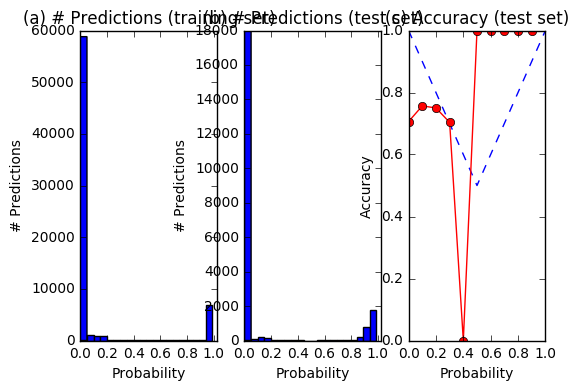

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.347121432027
Neg. class accuracy: 1.0
Corpus Precision 1.0
Corpus Recall    0.347
Corpus F1        0.515
----------------------------------------
TP: 2870 | FP: 0 | TN: 13034 | FN: 5398

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.347121432027
Neg. class accuracy: 1.0
Corpus Precision 1.0
Corpus Recall    0.347
Corpus F1        0.515
----------------------------------------
TP: 2870 | FP: 0 | TN: 13034 | FN: 5398



In [5]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()

dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates -- Gold').one()

from snorkel.models import CandidateSet
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Development Labels -- Gold')

tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [6]:
from snorkel.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Development').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, corpus, 'c_current_max')


Scoring on Entity-Level Gold Data
Corpus Precision 1.0
Corpus Recall    0.85
Corpus F1        0.919
----------------------------------------
TP: 170 | FP: 0 | FN: 30



In [7]:
from pprint import pprint
FN_list = sorted(list(FN))
FP_list = sorted(list(FP))
TP_list = sorted(list(TP))
pprint(FP_list[:60])

[]


In [ ]:
from hardware_utils import current_entity_to_candidates

entity = FP_list[18]
print entity
print

matches = current_entity_to_candidates(entity, fp)
print "# Matches: %d" % len(matches)
candidate = matches[0]
print candidate
print

print disc_model.get_candidate_score(candidate, F_dev)
print
pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

In [ ]:

import os
os.system('cp snorkel.db snorkel.db\ final');